In [142]:
import re
import nltk

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder

from pytorchtools_st import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [71]:
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.snowball import SnowballStemmer

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## 1. Классификация фамилий (RNN)

Датасет: https://disk.yandex.ru/d/frNchuaBQVLxyA?w=1

1.1 Используя класс `nn.RNNCell` (абстракцию для отдельного временного шага RNN), реализуйте простейшую рекуррентную сеть Элмана в виде класса `RNN`. Используя созданный класс `RNN`, решите задачу классификации фамилий. 


In [ ]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size):
    pass

  def forward(self, x, h=None):
    '''
    x.shape = (batch_size, seq_len, feature_size) - тензор входных данных
    h.shape = (batch_size, hidden_size) - тензор со скрытым состоянием RNN
    '''
    # инициализация тензора скрытых состояний
    # h = ...

    # проход по каждому элементу последовательностей s в батче и обновление скрытого состояния
    # h = RNNCell(s_t, h)

    # вернуть тензор всех наблюдавшихся скрытых состояний размера (batch_size, seq_len, hidden_size) и тензор скрытых состояний в последний момент времени

1.2 Замените модуль `RNN` из 1.1 на модули `nn.RNN`, `nn.LSTM` и `nn.GRU` (не забудьте указать аргумент `batch_first=True`). Сравните результаты работы.

In [4]:
text = [...]
batch_size = 5 # кол-во предложений в тексте
# разбиваем каждое предложение на слова и заменяем слова на их индексы
# выравниваем длины всех предложений 
vocab_size, max_seq_len = 100, 10
X = torch.randint(0, vocab_size, size = (batch_size, max_seq_len))
X

tensor([[ 5, 56, 26, 54, 23, 55, 98, 84, 71,  0],
        [17, 48, 54, 20, 36,  9, 28, 79, 80, 52],
        [60, 74, 16, 84, 87, 69, 42, 51, 46, 76],
        [78, 11, 15, 63, 36, 57, 17, 10, 63, 97],
        [91, 92,  9, 22, 34, 83, 96, 26, 81, 82]])

In [5]:
embedding_dim = 32
embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = 0) # padding_idx - индекс заглушки
X_embed = embedding(X)
X_embed.shape

torch.Size([5, 10, 32])

In [6]:
hidden_size = 50
rnn = nn.RNN(input_size = embedding_dim, hidden_size = hidden_size, batch_first = True)
out, hidden = rnn(X_embed) # hidden скрытое состояние rnn

In [7]:
out.shape, hidden.shape 

(torch.Size([5, 10, 50]), torch.Size([1, 5, 50]))

In [12]:
out[0, -1, :] # out состоит из последовательного состояния моделей

tensor([-0.3676,  0.2307,  0.0875,  0.4472,  0.0499,  0.2783, -0.0512,  0.1262,
        -0.1888, -0.1862, -0.4088,  0.4164, -0.3664, -0.1786,  0.1322,  0.2051,
         0.0358,  0.1660, -0.0310, -0.4318, -0.1267,  0.2529,  0.0251,  0.1898,
        -0.1474, -0.2167, -0.2638,  0.3574, -0.2139, -0.0804, -0.6871, -0.2189,
         0.2469, -0.1944, -0.5440, -0.0072, -0.1631,  0.1308,  0.2934,  0.0707,
        -0.4162,  0.0688,  0.0574, -0.1216, -0.0467, -0.2810, -0.0500,  0.2184,
        -0.2158,  0.0792], grad_fn=<SliceBackward>)

In [15]:
hidden[0, 0, :] # скрытое состояние модели на первом примере из батча, когда она закончила его обрабатывать

tensor([-0.3676,  0.2307,  0.0875,  0.4472,  0.0499,  0.2783, -0.0512,  0.1262,
        -0.1888, -0.1862, -0.4088,  0.4164, -0.3664, -0.1786,  0.1322,  0.2051,
         0.0358,  0.1660, -0.0310, -0.4318, -0.1267,  0.2529,  0.0251,  0.1898,
        -0.1474, -0.2167, -0.2638,  0.3574, -0.2139, -0.0804, -0.6871, -0.2189,
         0.2469, -0.1944, -0.5440, -0.0072, -0.1631,  0.1308,  0.2934,  0.0707,
        -0.4162,  0.0688,  0.0574, -0.1216, -0.0467, -0.2810, -0.0500,  0.2184,
        -0.2158,  0.0792], grad_fn=<SliceBackward>)

In [16]:
out = hidden[0] # Последнее скрытое состояние
out.shape
# Дальше fully connected layers

torch.Size([5, 50])

Реализуем фамилили

In [17]:
df = pd.read_csv('/content/drive/MyDrive/datasets/surnames.csv')
df.head()

,surname,nationality
0,Woodford,English
1,Coté,French
2,Kore,English
3,Koury,Arabic
4,Lebzak,Russian


In [18]:
label_enc = LabelEncoder()
df['label_nationality'] = label_enc.fit_transform(df['nationality'])
df.head()

,surname,nationality,label_nationality
0,Woodford,English,4
1,Coté,French,5
2,Kore,English,4
3,Koury,Arabic,0
4,Lebzak,Russian,14


In [19]:
X_train, X_test, y_train, y_test = train_test_split(df['surname'], df['label_nationality'], test_size = 0.2)

In [20]:
class Vocab:
  def __init__(self, data):
    tokens = set()
    for surname in data:
      tokens.update(surname)

    self.max_seq_len = max([len(val) for val in data])
    
    self.idx_to_token = {(idx+1): token for idx, token in enumerate(tokens)} # Индекс токен: буква
    self.idx_to_token[0] = '<PAD>'
    self.token_to_idx = {token: idx for idx, token in self.idx_to_token.items()} # обратный первому
    self.vocab_len = len(self.idx_to_token)

In [21]:
vocab = Vocab(df['surname'])
vocab.max_seq_len, vocab.vocab_len

(17, 85)

In [22]:
class SurnamesDataset(Dataset):
  def __init__(self, X, y, vocab: Vocab):
    self.X = X
    self.y = y
    self.vocab = vocab

  def vectorize(self, surname):
    '''Генерирует представление отзыва review в виде bag of words (см. 1.2.1)'''
    # ДОПОЛНИТЬ НУЛЯМИ ВЗАДИ
    surname_t = torch.zeros(self.vocab.max_seq_len, dtype = int)
    
    for idx, char in enumerate(surname):
      surname_t[idx] = self.vocab.token_to_idx[char]
    
    return surname_t

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.vectorize(self.X[idx]), self.y[idx]

In [52]:
class RNNSurnameNet(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_size, n_classes):
    super().__init__()

    self.embeddings = nn.Embedding(vocab_size, embedding_dim)

    self.rnn = nn.RNN(input_size = embedding_dim, 
                       hidden_size = hidden_size,
                       num_layers = 2, 
                       nonlinearity = 'tanh',
                       batch_first = True)
    
    self.fc = nn.Sequential(nn.Flatten(),
                            nn.Linear(64, 64), # было 64*4
                            nn.ReLU(),
                            nn.Linear(64, n_classes))
    
  def forward(self, input):
    embed = self.embeddings(input)
    out, hidden = self.rnn(embed)
    out = hidden[0]
    # print(out.shape)
    out = self.fc(out)
    return out

In [53]:
dataset_train = SurnamesDataset(list(X_train), list(y_train), vocab)
train_data = DataLoader(dataset_train, batch_size = 32, shuffle = True)

vocab_size = vocab.vocab_len
hidden_size = 64
embedding_dim = 16
n_classes = y_train.nunique()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model  = RNNSurnameNet(vocab_size = vocab_size, 
                       embedding_dim = embedding_dim, 
                       hidden_size = hidden_size,
                       n_classes = n_classes).to(device = device)
                       
criteriation = nn.CrossEntropyLoss()
optimazer = optim.Adam(model.parameters(), lr = 0.001, weight_decay = 5*10**(-4))

early_stop = EarlyStopping(patience = 3, verbose = False, delta = 0.001)

loss_history = list()
epochs_history = list()

n_epochs = 500

for epoch in range(1, n_epochs + 1):
  loss_batch = 0

  for X_batch, y_batch in train_data:
    X_batch, y_batch = X_batch.to(device = device), y_batch.to(device = device)
    out = model(X_batch)

    cur_loss = criteriation(out, y_batch)
    loss_batch += cur_loss

    cur_loss.backward()
    optimazer.step()
    optimazer.zero_grad()

  loss_history.append(loss_batch/len(train_data))
  epochs_history.append(epoch)

  if epoch % 2:
    print(f'Epoch: [{epoch}/{n_epochs}]: Loss_Train = {loss_history[-1]}')

  early_stop(loss_history[-1], model)

  if early_stop.early_stop:
      print(f"Early stopping on epoch: [{epoch}/{n_epochs}] with Loss_Train = {loss_history[-1]}")
      break

torch.save(model, '/content/drive/MyDrive/models/RNN_embedding_Surname_(b_6_t_2).pth')

Epoch: [1/500]: Loss_Train = 2.243314743041992
Epoch: [3/500]: Loss_Train = 1.9492017030715942
Epoch: [5/500]: Loss_Train = 1.8427411317825317
Epoch: [7/500]: Loss_Train = 1.733414888381958
Epoch: [9/500]: Loss_Train = 1.6668390035629272
Epoch: [11/500]: Loss_Train = 1.5982948541641235
Epoch: [13/500]: Loss_Train = 1.5042191743850708
Epoch: [15/500]: Loss_Train = 1.4291319847106934
Epoch: [17/500]: Loss_Train = 1.3721483945846558
Epoch: [19/500]: Loss_Train = 1.3273353576660156
Epoch: [21/500]: Loss_Train = 1.2691913843154907
Epoch: [23/500]: Loss_Train = 1.2348103523254395
Epoch: [25/500]: Loss_Train = 1.2109423875808716
EarlyStopping counter: 1 out of 3
Epoch: [27/500]: Loss_Train = 1.1564205884933472
Epoch: [29/500]: Loss_Train = 1.134515404701233
EarlyStopping counter: 1 out of 3
Epoch: [31/500]: Loss_Train = 1.1086958646774292
Epoch: [33/500]: Loss_Train = 1.0777677297592163
EarlyStopping counter: 1 out of 3
EarlyStopping counter: 2 out of 3
Epoch: [35/500]: Loss_Train = 1.0588510

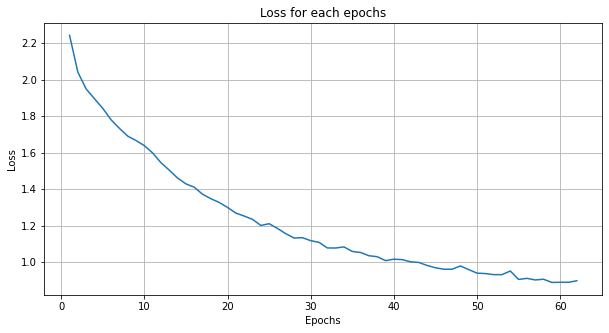

In [54]:
fig, ax = plt.subplots(figsize = (10, 5))
plt.plot(epochs_history, loss_history)
plt.title('Loss for each epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()

In [57]:
dataset_train = SurnamesDataset(list(X_test), list(y_test), vocab)
train_data = DataLoader(dataset_train, batch_size = len(dataset_train), shuffle = True)

correct, total = 0, 0
with torch.no_grad():
  for X_batch, y_batch in train_data:
    X_batch = X_batch.to(device = device)#, y_batch.to(device = device)
    pred = model(X_batch)

    _, predicted = torch.max(pred, dim = 1)
    predicted = predicted.to(device = 'cpu')
    total += y_batch.shape[0]
    correct += int((predicted == y_batch).sum())

    f1 = f1_score(y_batch.numpy(), predicted.numpy(), average='weighted') # weighted, т.к. дисбаланс классов

print(f'Accuracy: {correct/total}')

print(f'F1: {f1}')

Accuracy: 0.6912568306010929
F1: 0.6455585343772303


In [58]:
X_classmates = ['Semenov', 'Zaraev', 'Ragimov']
y_fictit = [0, 0, 0]

classmats = SurnamesDataset(X_classmates, y_fictit, vocab)
train_data = DataLoader(classmats, batch_size = 1, shuffle = True)

with torch.no_grad():
  for idx, (x, y) in enumerate(train_data):
    x = x.to(device = device)
    out = model(x)
    _, ind = torch.sort(out)
    ind = ind[0]
    ind = ind.to(device = 'cpu')
    print(f'Наиболее вероятные нациаональности для фамилии {X_classmates[idx]}:')
    for id, v in enumerate(ind[-3:]):
      ans = list(set(df[df['label_nationality'] == v.item()]['nationality']))[0]
      print(f'{abs(id - 3)}) {ans}')

Наиболее вероятные нациаональности для фамилии Semenov:
3) Polish
2) Czech
1) Russian
Наиболее вероятные нациаональности для фамилии Zaraev:
3) Chinese
2) Czech
1) Russian
Наиболее вероятные нациаональности для фамилии Ragimov:
3) Chinese
2) Czech
1) Russian


1.3 Загрузите предобученные эмбеддинги (https://disk.yandex.ru/d/BHuT2tEXr_yBOQ?w=1) в модуль `nn.Embedding` и обучите модели из 1.2.

In [ ]:
# Слова в файле идет не в том порядке и некоторых слов может не быть (тогда инциализируем случайными весами отсутствующее слово)

In [61]:
with open('/content/drive/MyDrive/embeddings/globe_100_rows.txt', 'r', encoding = 'utf8') as femb:
  for line in femb:
    print(line)
    word, *emb = line.split(' ')
    break

the 0.418 0.24968 -0.41242 0.1217 0.34527 -0.044457 -0.49688 -0.17862 -0.00066023 -0.6566 0.27843 -0.14767 -0.55677 0.14658 -0.0095095 0.011658 0.10204 -0.12792 -0.8443 -0.12181 -0.016801 -0.33279 -0.1552 -0.23131 -0.19181 -1.8823 -0.76746 0.099051 -0.42125 -0.19526 4.0071 -0.18594 -0.52287 -0.31681 0.00059213 0.0074449 0.17778 -0.15897 0.012041 -0.054223 -0.29871 -0.15749 -0.34758 -0.045637 -0.44251 0.18785 0.0027849 -0.18411 -0.11514 -0.78581



In [62]:
vocab.token_to_idx.keys()

dict_keys(['è', 'ż', 'ö', 'ó', 'ù', 'ç', 'b', 'J', 't', 'e', 'T', 'ä', 'N', 'h', 'M', 'ã', 'E', 'í', 'a', 'õ', 'V', 'ú', 'ń', 'o', 'Y', 'q', 'É', 'C', 'á', 'Z', 'j', 'p', 'Ś', 'é', 'I', 'Q', 'O', "'", 'ñ', 'f', 'n', 'A', 'w', 'U', 'ê', 'i', 'D', ':', 'L', 'ą', 'ł', 'z', 'y', 'd', 'R', 'ì', 'G', 'X', 'W', 'u', '/', '1', 'ò', 'ß', 'r', 'Á', 'm', 'H', 'Ż', 'c', 'x', 'à', 'K', 's', 'v', 'k', 'l', 'S', 'B', 'P', 'F', 'ü', '-', 'g', '<PAD>'])

## 2. Классификация обзоров на фильмы (RNN)

Датасет: https://disk.yandex.ru/d/tdinpb0nN_Dsrg

2.1 Создайте набор данных на основе файлов polarity/positive_reviews.csv (положительные отзывы) и polarity/negative_reviews.csv (отрицательные отзывы). Разбейте на обучающую и тестовую выборку.
  * токен = __слово__
  * данные для обучения в датасете представляются в виде последовательности индексов токенов
  * словарь создается на основе _только_ обучающей выборки. Для корректной обработки ситуаций, когда в тестовой выборке встретится токен, который не хранится в словаре, добавьте в словарь специальный токен `<UNK>`
  * добавьте предобработку текста

2.2. Обучите классификатор.
  
  * Для преобразования последовательности индексов в последовательность векторов используйте `nn.Embedding` 
    - подберите адекватную размерность вектора эмбеддинга: 
    - модуль `nn.Embedding` обучается

  * Используйте рекуррентные слои (`nn.RNN`, `nn.LSTM`, `nn.GRU`)


2.3 Измерить точность на тестовой выборке. Проверить работоспособность модели: придумать небольшой отзыв, прогнать его через модель и вывести номер предсказанного класса (сделать это для явно позитивного и явно негативного отзыва)
* Целевое значение accuracy на валидации - 70+%

In [120]:
def read_text(path):
  with open(path, 'r', encoding = 'utf-8') as pos:
    posit = list()
    for line in pos:
      posit.append(line.rstrip())
    return posit

pos_file = read_text('/content/drive/MyDrive/datasets/polarity/positive_reviews.txt')
df_pos = pd.DataFrame({'review': pos_file, 'label': [0 for i in range(len(pos_file))]})
print(f'count positive reviews: {df_pos.shape[0]}')

neg_file = read_text('/content/drive/MyDrive/datasets/polarity/negative_reviews.txt')
df_neg = pd.DataFrame({'review': neg_file, 'label': [1 for i in range(len(neg_file))]})

print(f'count negative reviews: {df_neg.shape[0]}')

df = pd.concat([df_pos, df_neg], ignore_index=True)

display(df.sample(10)), df.shape

count positive reviews: 5331
count negative reviews: 5331


,review,label
332,"it is messy , uncouth , incomprehensible , vic...",0
8020,while tattoo borrows heavily from both seven a...,1
10518,jones has tackled a meaty subject and drawn en...,1
520,in the name of an allegedly inspiring and easi...,0
5513,a very funny movie .,1
8484,intimate and panoramic .,1
6313,"without resorting to hyperbole , i can state t...",1
460,the movie attempts to mine laughs from a genre...,0
7083,"a slick , engrossing melodrama .",1
4321,not good enough to pass for a litmus test of t...,0


(None, (10662, 2))

In [124]:
# предобработка текста
for idx, rev in enumerate(df['review']):
  rev = re.sub(r"[^a-zA-Z.,!]", " ", rev)
  # rev = re.sub(r"[[]]", "", rev)
  df.loc[idx, 'review'] = rev.lower() 

print(df.shape)
df.sample(5)

(10662, 2)


,review,label
1783,there seems to be no clear path as to where th...,0
4951,"theological matters aside , the movie is so cl...",0
4065,"god is great , the movie s not .",0
3423,one of the most highly praised disappointments...,0
10593,the story itself it mostly told through on cam...,1


In [132]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
lemat = WordNetLemmatizer()

In [129]:
# Скачиваем набор стоп-слов
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [126]:
stop_words = stopwords.words('english') # Загрузка стоп-слов

df['review_new'] = [' ' for rev in range(len(df))]

for idx, txt in enumerate(df['review']):
  tokens = []
  for sent in sent_tokenize(txt): # лексемазация предложения
    for word in word_tokenize(sent): # лексемазация слов
      tokens.append(lemat.lemmatize(word,  pos = 'v'))

  # Удаление stop-words in tarin dataset
  rev_new = ' '.join([word for word in tokens if word not in stop_words])
  df.loc[idx, 'review_new'] = rev_new

df

,review,label,review_new
0,"simplistic , silly and tedious .",0,"simplistic , silly tedious ."
1,"it s so laddish and juvenile , only teenage bo...",0,"laddish juvenile , teenage boys could possibly..."
2,exploitative and largely devoid of the depth o...,0,exploitative largely devoid depth sophisticati...
3,garbus discards the potential for pathologic...,0,"garbus discard potential pathological study , ..."
4,a visually flashy but narratively opaque and e...,0,visually flashy narratively opaque emotionally...
...,...,...,...
10657,both exuberantly romantic and serenely melanch...,1,"exuberantly romantic serenely melancholy , tim..."
10658,mazel tov to a film about a family s joyous li...,1,mazel tov film family joyous life act yiddish ...
10659,standing in the shadows of motown is the best ...,1,"stand shadow motown best kind documentary , on..."
10660,it s nice to see piscopo again after all these...,1,"nice see piscopo years , chaykin headly pricel..."


In [130]:
X_train, X_test, y_train, y_test = train_test_split(df['review_new'], df['label'], test_size = 0.1, stratify = df['label'])

In [131]:
len(y_train[y_train == 0])/len(y_train), len(y_test[y_test == 0])/len(y_test)

(0.5000521104742053, 0.49953139643861294)

In [133]:
class Vocab:
  def __init__(self, data):
    tokens = [] # Все слова в словаре
    for txt in data:
      for sent in sent_tokenize(txt): # лексемазация предложения
        for word in word_tokenize(sent): # лексемазация слов
          tokens.append(lemat.lemmatize(word,  pos = 'v'))
    
    self.max_seq_len = max([len(word_tokenize(txt)) for txt in data]) # максимальная длина одного отзыва

    tokens = set(tokens)

    self.idx_to_token = {(idx + 1): token for idx, token in enumerate(tokens)}
    self.idx_to_token[0] = '<PAD>'
    self.idx_to_token[len(tokens) + 1] = '<UNK>'
    self.UNK = len(tokens) + 1
    self.token_to_idx = {token: idx for idx, token in self.idx_to_token.items()} # токен слово
    self.vocab_len = len(self.idx_to_token)

In [134]:
vocab = Vocab(X_train)
vocab.max_seq_len, vocab.vocab_len

(41, 14099)

In [135]:
vocab.token_to_idx['<UNK>']

14098

In [136]:
class ReviewMovieDataset(Dataset):
  def __init__(self, X, y, vocab: Vocab):
    self.X = X
    self.y = y
    self.vocab = vocab

  def vectorize(self, review):
    '''Генерирует представление отзыва review в виде bag of words (см. 1.2.1)'''
    # ДОПОЛНИТЬ НУЛЯМИ ВЗАДИ
    review_t = torch.zeros(self.vocab.max_seq_len, dtype = int)
    
    for idx, word in enumerate(word_tokenize(review)):
        if word in self.vocab.token_to_idx.keys():
          review_t[idx] = self.vocab.token_to_idx[word]
        else:
          review_t[idx] = self.vocab.token_to_idx['<UNK>']
    
    return review_t

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.vectorize(self.X[idx]), self.y[idx]

In [137]:
dataset_train = ReviewMovieDataset(list(X_train), list(y_train), vocab)
dataset_train[0]

(tensor([ 6517,  4092,  7312,  9062,  7312,  7312,  6075,  2588,  8182,  3762,
          8421, 10924,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0]), 1)

In [282]:
class CNNReviewMovieNet(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_size, n_classes, residual = 'RNN'):
    super().__init__()

    self.embeddings = nn.Embedding(vocab_size, embedding_dim)
    
    self.residual = residual.lower()

    if self.residual == 'rnn':
      self.rl = nn.RNN(input_size = embedding_dim, 
                        hidden_size = hidden_size,
                        num_layers = 1, 
                        nonlinearity = 'relu',
                        batch_first = True)
                        # dropout = 0.5)
      
    elif self.residual == 'lstm':
      self.rl = nn.LSTM(input_size = embedding_dim, 
                        hidden_size = hidden_size,
                        batch_first = True)  
                        # dropout = 0.5)    

    elif self.residual == 'gru':
      self.rl = nn.LSTM(input_size = embedding_dim, 
                        hidden_size = hidden_size,
                        batch_first = True) 
                        # dropout = 0.5)

    self.fc = nn.Linear(hidden_size, n_classes)
    # self.fc = nn.Sequential(nn.Flatten(),
    #                         nn.Linear(hidden_size, 32), # Для RNN первый аргумент является hidden_size
    #                         nn.BatchNorm1d(32),
    #                         nn.ReLU(),
    #                         # nn.Linear(256, 128),
    #                         # nn.BatchNorm1d(128),
    #                         # nn.ReLU(),
    #                         # nn.Linear(128, 64),
    #                         # nn.BatchNorm1d(64),
    #                         # nn.ReLU(),
    #                         # nn.Linear(128, 64),
    #                         # nn.BatchNorm1d(64),
    #                         # nn.ReLU(),
    #                         nn.Linear(32, n_classes))
    
  def forward(self, input):
    embed = self.embeddings(input)
    print(embed.shape)
    out, hidden = self.rl(embed)
    out = hidden[0]
    print(out.shape)
    out = self.fc(out)
    return out

In [232]:
dataset_train = ReviewMovieDataset(list(X_train), list(y_train), vocab)

train_size = int(np.floor(0.8 * len(dataset_train)))
val_size = len(dataset_train) - train_size

train_dataset, test_dataset = random_split(dataset_train, [train_size, val_size])

train_data = DataLoader(train_dataset, batch_size = 32, shuffle = True)
validation = DataLoader(test_dataset, batch_size = 32, shuffle = True)

vocab_size = vocab.vocab_len
hidden_size = 64
embedding_dim = 128
n_classes = y_train.nunique()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model  = CNNReviewMovieNet(vocab_size = vocab_size, 
                           embedding_dim = embedding_dim,
                           hidden_size = hidden_size,
                           n_classes = n_classes,
                           residual = 'rnn').to(device = device)

criteriation = nn.CrossEntropyLoss()
optimazer = optim.Adam(model.parameters(), lr = 0.001, weight_decay = 5*10**(-4))

early_stop = EarlyStopping(patience = 4, verbose = False, delta = 0.0001)

loss_history = list()
history_loss_val = list()
epochs_history = list()
accuracy_val = list()

n_epochs = 500

for epoch in range(1, n_epochs + 1):
  loss_batch = 0
  loss_val = 0

  for X_batch, y_batch in train_data:
    X_batch, y_batch = X_batch.to(device = device), y_batch.to(device = device)
    out = model(X_batch)

    cur_loss = criteriation(out, y_batch)
    loss_batch += cur_loss

    cur_loss.backward()
    optimazer.step()
    optimazer.zero_grad()

  loss_history.append(loss_batch/len(train_data))
  epochs_history.append(epoch)

  correct_val, total_val = 0, 0

  with torch.no_grad():
    for X_val, y_val in validation:
      X_val, y_val = X_val.to(device = device), y_val.to(device = device)
      out = model(X_val)

      _, predicted = torch.max(out, dim = 1)

      total += y_val.shape[0]
      correct += int((predicted == y_val).sum())

      loss = criteriation(out, y_val)
      loss_val += loss

  history_loss_val.append(loss_val/len(train_data))
  accuracy_val.append(correct/total)

  if epoch % 2:
    print(f'Epoch: [{epoch}/{n_epochs}]: Loss_Train = {loss_history[-1]}, Loss_Val = {history_loss_val[-1]}, Accuracy_Val = {accuracy_val[-1]}')

  early_stop(accuracy_val[-1], model)

  if early_stop.early_stop: #and accuracy_val[-1] >= 0.7:
      print(f"Early stopping on epoch: [{epoch}/{n_epochs}] with Loss_Train = {loss_history[-1]}, Loss_Val = {history_loss_val[-1]}, Accuracy_Val = {accuracy_val[-1]}")
      break

torch.save(model, '/content/drive/MyDrive/models/RNN_embedding_ReviewMoves_(b_7_t_2).pth')

Epoch: [1/500]: Loss_Train = 0.6996273398399353, Loss_Val = 0.1731424480676651, Accuracy_Val = 0.4947537419093851
EarlyStopping counter: 1 out of 4
Epoch: [3/500]: Loss_Train = 0.6955304741859436, Loss_Val = 0.17309729754924774, Accuracy_Val = 0.4948292654380076
EarlyStopping counter: 2 out of 4
EarlyStopping counter: 3 out of 4
Epoch: [5/500]: Loss_Train = 0.6954693794250488, Loss_Val = 0.17336159944534302, Accuracy_Val = 0.49493261455525606
EarlyStopping counter: 4 out of 4
Early stopping on epoch: [5/500] with Loss_Train = 0.6954693794250488, Loss_Val = 0.17336159944534302, Accuracy_Val = 0.49493261455525606


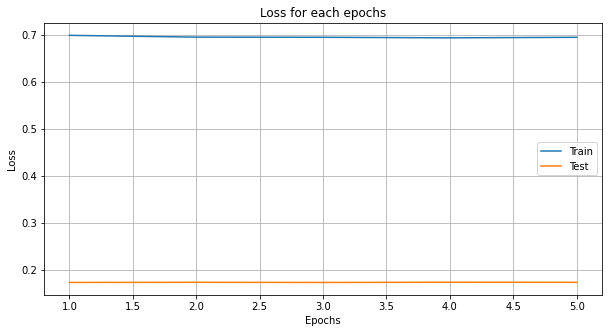

In [233]:
fig, ax = plt.subplots(figsize = (10, 5))
plt.plot(epochs_history, loss_history, label = 'Train')
plt.plot(epochs_history, history_loss_val, label = 'Test')
plt.legend()
plt.title('Loss for each epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()

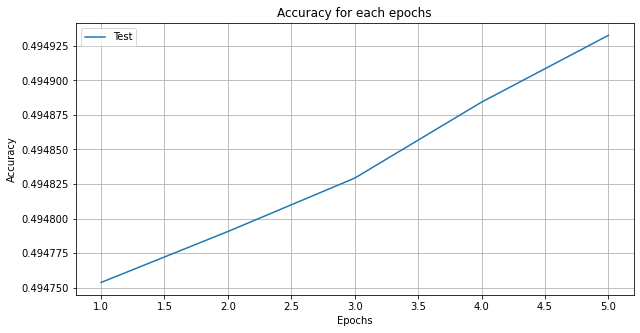

In [234]:
fig, ax = plt.subplots(figsize = (10, 5))
plt.plot(epochs_history, accuracy_val, label = 'Test')
plt.legend()
plt.title('Accuracy for each epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()

In [235]:
dataset_train = ReviewMovieDataset(list(X_test), list(y_test), vocab)
train_data = DataLoader(dataset_train, batch_size = len(dataset_train), shuffle = True)

correct, total = 0, 0
with torch.no_grad():
  for X_batch, y_batch in train_data:
    X_batch, y_batch = X_batch.to(device = device), y_batch.to(device = device)
    pred = model(X_batch)

    _, predicted = torch.max(pred, dim = 1)
    total += y_batch.shape[0]
    correct += int((predicted == y_batch).sum())

    # f1 = f1_score(y_batch.numpy(), predicted.numpy(), average='weighted') # weighted, т.к. дисбаланс классов

print(f'Accuracy: {correct/total}')

# print(f'F1: {f1}')

Accuracy: 0.514526710402999


In [238]:
negative = 'The acting is bad because the idea of ​​the film is terrible.'
# negative = preprocess_text(negative)
positive = 'The director made a masterpiece.'
# positive = preprocess_text(positive)

X_classmates = [negative, positive]
y_fictit = [0, 0]

reviews = ReviewMovieDataset(X_classmates, y_fictit, vocab)
rev = DataLoader(reviews, batch_size = 1, shuffle = True)

model.eval()
with torch.no_grad():
  for x, y in rev:
    x = x.to(device = device)

    out = model(x)
    _, predicted = torch.max(out, dim = 1)
    
    print(predicted.item())

# 0 - позитивный отзыв
# 1 - негативный отзыв

0
0


In [281]:
dataset_train = ReviewMovieDataset(list(X_train), list(y_train), vocab)

train_size = int(np.floor(0.8 * len(dataset_train)))
val_size = len(dataset_train) - train_size

train_dataset, test_dataset = random_split(dataset_train, [train_size, val_size])

train_data = DataLoader(train_dataset, batch_size = 32, shuffle = True)
validation = DataLoader(test_dataset, batch_size = 32, shuffle = True)

vocab_size = vocab.vocab_len
hidden_size = 64
embedding_dim = 128
n_classes = y_train.nunique()

model_lstm  = CNNReviewMovieNet(vocab_size = vocab_size, 
                           embedding_dim = embedding_dim,
                           hidden_size = hidden_size,
                           n_classes = n_classes,
                           residual = 'lstm').to(device = device)

early_stop = EarlyStopping(patience = 4, verbose = False, delta = 0.0001)

loss_history = list()
history_loss_val = list()
epochs_history = list()
accuracy_val = list()

n_epochs = 500

for epoch in range(1, n_epochs + 1):
  loss_batch = 0
  loss_val = 0

  for X_batch, y_batch in train_data:
    X_batch, y_batch = X_batch.to(device = device), y_batch.to(device = device)
    out = model_lstm(X_batch)

    cur_loss = criteriation(out, y_batch)
    loss_batch += cur_loss

    cur_loss.backward()
    optimazer.step()
    optimazer.zero_grad()

  loss_history.append(loss_batch/len(train_data))
  epochs_history.append(epoch)

  correct_val, total_val = 0, 0

  with torch.no_grad():
    for X_val, y_val in validation:
      X_val, y_val = X_val.to(device = device), y_val.to(device = device)
      out = model_lstm(X_val)

      _, predicted = torch.max(out, dim = 1)

      total += y_val.shape[0]
      correct += int((predicted == y_val).sum())

      loss = criteriation(out, y_val)
      loss_val += loss

  history_loss_val.append(loss_val/len(train_data))
  accuracy_val.append(correct/total)

  if epoch % 2:
    print(f'Epoch: [{epoch}/{n_epochs}]: Loss_Train = {loss_history[-1]}, Loss_Val = {history_loss_val[-1]}, Accuracy_Val = {accuracy_val[-1]}')

  early_stop(accuracy_val[-1], model)

  if early_stop.early_stop: #and accuracy_val[-1] >= 0.7:
      print(f"Early stopping on epoch: [{epoch}/{n_epochs}] with Loss_Train = {loss_history[-1]}, Loss_Val = {history_loss_val[-1]}, Accuracy_Val = {accuracy_val[-1]}")
      break

torch.save(model, '/content/drive/MyDrive/models/RNN_embedding_ReviewMoves_(b_7_t_2).pth')

torch.Size([32, 41, 128])
torch.Size([1, 32, 64])


ValueError: ignored

In [283]:
dataset_train = ReviewMovieDataset(list(X_train), list(y_train), vocab)

train_size = int(np.floor(0.8 * len(dataset_train)))
val_size = len(dataset_train) - train_size

train_dataset, test_dataset = random_split(dataset_train, [train_size, val_size])

train_data = DataLoader(train_dataset, batch_size = 32, shuffle = True)
validation = DataLoader(test_dataset, batch_size = 32, shuffle = True)

vocab_size = vocab.vocab_len
hidden_size = 64
embedding_dim = 128
n_classes = y_train.nunique()

model_lstm  = CNNReviewMovieNet(vocab_size = vocab_size, 
                           embedding_dim = embedding_dim,
                           hidden_size = hidden_size,
                           n_classes = n_classes,
                           residual = 'gru').to(device = device)

early_stop = EarlyStopping(patience = 4, verbose = False, delta = 0.0001)

loss_history = list()
history_loss_val = list()
epochs_history = list()
accuracy_val = list()

n_epochs = 500

for epoch in range(1, n_epochs + 1):
  loss_batch = 0
  loss_val = 0

  for X_batch, y_batch in train_data:
    X_batch, y_batch = X_batch.to(device = device), y_batch.to(device = device)
    out = model_lstm(X_batch)

    cur_loss = criteriation(out, y_batch)
    loss_batch += cur_loss

    cur_loss.backward()
    optimazer.step()
    optimazer.zero_grad()

  loss_history.append(loss_batch/len(train_data))
  epochs_history.append(epoch)

  correct_val, total_val = 0, 0

  with torch.no_grad():
    for X_val, y_val in validation:
      X_val, y_val = X_val.to(device = device), y_val.to(device = device)
      out = model_lstm(X_val)

      _, predicted = torch.max(out, dim = 1)

      total += y_val.shape[0]
      correct += int((predicted == y_val).sum())

      loss = criteriation(out, y_val)
      loss_val += loss

  history_loss_val.append(loss_val/len(train_data))
  accuracy_val.append(correct/total)

  if epoch % 2:
    print(f'Epoch: [{epoch}/{n_epochs}]: Loss_Train = {loss_history[-1]}, Loss_Val = {history_loss_val[-1]}, Accuracy_Val = {accuracy_val[-1]}')

  early_stop(accuracy_val[-1], model)

  if early_stop.early_stop: #and accuracy_val[-1] >= 0.7:
      print(f"Early stopping on epoch: [{epoch}/{n_epochs}] with Loss_Train = {loss_history[-1]}, Loss_Val = {history_loss_val[-1]}, Accuracy_Val = {accuracy_val[-1]}")
      break

torch.save(model, '/content/drive/MyDrive/models/RNN_embedding_ReviewMoves_(b_7_t_2).pth')

torch.Size([32, 41, 128])
torch.Size([1, 32, 64])


ValueError: ignored